In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This code sets up the necessary libraries/modules and checks whether CUDA (GPU support) is available, assigning the appropriate device ("cuda" or "cpu") for computation:

In [ ]:
pip install torch-geometric

In [ ]:
# Import the necessary libraries/modules
import torch  # PyTorch library for deep learning
from torch.jit import script, trace  # For script and trace in PyTorch
import torch.nn as nn  # Neural network module in PyTorch
from torch import optim  # Optimisation module in PyTorch
import torch.nn.functional as F  # Functional operations for neural networks
import csv  # Comma Separated Values (CSV) file handling
import random  # Random number generation
import re  # Regular expressions for text processing
import os  # Operating system interface
import unicodedata  # Unicode character database
import codecs  # Codec support for reading and writing text files
from io import open  # Input/output operations with text files
import itertools  # Iteration utilities
import math  # Mathematical operations
import json  # JSON (JavaScript Object Notation) handling
import torch_geometric  # For GCN implementation in PyTorch
from torch_geometric.nn import GCNConv  # GCN convolution layer
import networkx as nx  # For graph manipulation

# Check if CUDA (GPU support) is available, and set the device accordingly
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

This code defines a function printLines that reads and prints the first 'n' lines from a given file. Then, it calls this function with the path to the "utterances.jsonl" file within the "movie-corpus" directory:

In [ ]:
import os  # Import the 'os' module to work with file paths.

# Define the name of the corpus folder.
corpus_name = "movie-corpus"

# Create a file path by joining "data" and the corpus_name.
corpus = os.path.join("movie-corpus", corpus_name)

# Define a function called 'printLines' that takes a file path and an optional argument 'n'.
def printLines(file, n=10):
    # Open the file in binary read mode and assign it to the 'datafile' variable.
    with open(file, 'rb') as datafile:
        # Read all lines from the file and store them in the 'lines' list.
        lines = datafile.readlines()

    # Loop through the first 'n' lines (default is 10) in the 'lines' list.
    for line in lines[:n]:
        # Print each line to the console.
        print(line)

# Call the 'printLines' function with the file path to "utterances.jsonl" in the 'corpus' folder.
printLines(os.path.join(corpus, "utterances.jsonl"))

b'{"id": "L1045", "conversation_id": "L1044", "text": "They do not!", "speaker": "u0", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "not", "tag": "RB", "dep": "neg", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": "L1044", "timestamp": null, "vectors": []}\n'
b'{"id": "L1044", "conversation_id": "L1044", "text": "They do to!", "speaker": "u2", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "to", "tag": "TO", "dep": "dobj", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": null, "timestamp": null, "vectors": []}\n'
b'{"id": "L985", "conversation_id": "L984", "text": "I hope so.", "speaker": "u0", "meta": {

These functions are used for loading lines and conversations from a file, as well as extracting pairs of sentences from those conversations:

In [ ]:
# Function to load lines and conversations from a file
def loadLinesAndConversations(fileName):
    lines = {}  # Dictionary to store individual lines
    conversations = {}  # Dictionary to store conversations
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            lineJson = json.loads(line)  # Parse the JSON data from each line
            # Extract fields for line object
            lineObj = {}
            lineObj["lineID"] = lineJson["id"]
            lineObj["characterID"] = lineJson["speaker"]
            lineObj["text"] = lineJson["text"]
            lines[lineObj['lineID']] = lineObj  # Store the line object in the 'lines' dictionary

            # Extract fields for conversation object
            if lineJson["conversation_id"] not in conversations:
                convObj = {}
                convObj["conversationID"] = lineJson["conversation_id"]
                convObj["movieID"] = lineJson["meta"]["movie_id"]
                convObj["lines"] = [lineObj]
            else:
                convObj = conversations[lineJson["conversation_id"]]
                convObj["lines"].insert(0, lineObj)
            conversations[convObj["conversationID"]] = convObj  # Store the conversation object in the 'conversations' dictionary

    return lines, conversations


# Function to extract pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []  # List to store question-answer pairs
    for conversation in conversations.values():
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter out wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])  # Add the pair to the list
    return qa_pairs

This code prepares and processes data from the "utterances.jsonl" file, formats it, and saves it to a new CSV file named "formatted_movie_lines.txt."

In [ ]:
# Define the path to the new file where formatted data will be saved
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

# Define the delimiter used to separate values in the CSV file
delimiter = '\t'

# Unescape the delimiter to handle escape sequences if necessary
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialise dictionaries to store lines and conversations
lines = {}  # Dictionary to store individual lines
conversations = {}  # Dictionary to store conversations

# Load lines and conversations from the "utterances.jsonl" file
print("\nProcessing corpus into lines and conversations...")
lines, conversations = loadLinesAndConversations(os.path.join(corpus, "utterances.jsonl"))

# Write the newly formatted data to a CSV file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines from the newly created file
print("\nSample lines from file:")
printLines(datafile)


Processing corpus into lines and conversations...

Writing newly formatted file...

Sample lines from file:
b'They do to!\tThey do not!\n'
b'She okay?\tI hope so.\n'
b"Wow\tLet's go.\n"
b'"I\'m kidding.  You know how sometimes you just become this ""persona""?  And you don\'t know how to quit?"\tNo\n'
b"No\tOkay -- you're gonna need to learn how to lie.\n"
b"I figured you'd get to the good stuff eventually.\tWhat good stuff?\n"
b'What good stuff?\t"The ""real you""."\n'
b'"The ""real you""."\tLike my fear of wearing pastels?\n'
b'do you listen to this crap?\tWhat crap?\n'
b"What crap?\tMe.  This endless ...blonde babble. I'm like, boring myself.\n"


This code defines a 'Voc' class for managing a vocabulary, adding words and sentences to it, and trimming it by removing words with low counts:

In [ ]:
# Define default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

# Define a vocabulary class to manage word-to-index and index-to-word mappings
class Voc:
    def __init__(self, name):
        self.name = name  # Name of the vocabulary
        self.trimmed = False  # Flag to indicate if vocabulary has been trimmed
        self.word2index = {}  # Dictionary mapping words to their index
        self.word2count = {}  # Dictionary to store word counts
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}  # Dictionary mapping indices to words with default tokens
        self.num_words = 3  # Initialise the count of words with default tokens (PAD, SOS, EOS)

    # Method to add a sentence to the vocabulary
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    # Method to add a word to the vocabulary
    def addWord(self, word):
        if word not in self.word2index:
            # If the word is not in the vocabulary, add it
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # If the word is already in the vocabulary, increment its count
            self.word2count[word] += 1

    # Method to trim the vocabulary by removing words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialise dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Reset word count to include default tokens

        for word in keep_words:
            self.addWord(word)

This code prepares training data by reading and normalizing pairs of sentences, filtering them based on sentence length, and creating a vocabulary object ('Voc') to manage word-to-index mappings:

In [ ]:
# Maximum sentence length to consider
MAX_LENGTH = 20

# Function to convert Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Function to normalize a string: lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())  # Convert to lowercase and strip spaces
    s = re.sub(r"([.!?])", r" \1", s)  # Add spaces around punctuation
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)  # Remove non-letter characters
    s = re.sub(r"\s+", r" ", s).strip()  # Remove extra spaces and strip
    return s

# Function to read query/response pairs and return a 'Voc' object and pairs list
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split it into lines
    lines = open(datafile, encoding='utf-8').read().strip().split('\n')
    # Split every line into pairs and normalize them
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # Create a 'Voc' object with the given 'corpus_name'
    voc = Voc(corpus_name)
    return voc, pairs

# Function to filter pairs based on sentence length (under MAX_LENGTH)
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Function to filter pairs using the 'filterPair' condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Function to load and prepare training data, returning a populated 'Voc' object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

# Define a save directory for the 'Voc' object and pairs list
save_dir = os.path.join("data", "save")

# Load and prepare data using the functions defined above
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)

# Print some example pairs to validate the data
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 145493 sentence pairs
Counting words...
Counted words: 33170

pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['no', 'okay you re gonna need to learn how to lie .']
['i figured you d get to the good stuff eventually .', 'what good stuff ?']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['do you listen to this crap ?', 'what crap ?']
['what crap ?', 'me . this endless . . .blonde babble . i m like boring myself .']
['me . this endless . . .blonde babble . i m like boring myself .', 'thank god ! if i had to hear one more story about your coiffure . . .']


This code defines a function 'trimRareWords' to trim rare words from the vocabulary ('voc') and filter pairs that do not contain trimmed words in their input or output sentences:

In [ ]:
# Minimum word count threshold for trimming
MIN_COUNT = 3

# Function to trim rare words from the vocabulary and filter pairs
def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used less than MIN_COUNT times from the vocabulary
    voc.trim(MIN_COUNT)

    # Initialise a list to keep pairs that do not contain trimmed words
    keep_pairs = []

    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True

        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break

        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs

# Trim rare words from the vocabulary and filter pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 17175 / 33167 = 0.5178
Trimmed from 145493 pairs to 126905, 0.8722 of total


These functions prepare the input and output tensors for training data, including padding and creating binary masks:

In [ ]:
# Function to convert a sentence to a list of indexes using the vocabulary
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

# Function to pad sequences with zeros to create a rectangular matrix
def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

# Function to create a binary matrix indicating the presence of padding tokens
def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Function to prepare input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Function to prepare target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Function to prepare all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    # Sort the pair batch by the length of the input sequences (for efficient padding)
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

# Example code for validation
small_batch_size = 5
# Create batches of training data with random pairs
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

# Print the prepared data for validation
print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[  37,  414,  123, 5432,   59],
        [3288,  256, 1031, 2143,  721],
        [ 167,   20,  474,   14,   10],
        [6119, 1127,   14,    2,    2],
        [6120,   79,    2,    0,    0],
        [ 186,   10,    0,    0,    0],
        [1085,    2,    0,    0,    0],
        [ 880,    0,    0,    0,    0],
        [ 414,    0,    0,    0,    0],
        [1507,    0,    0,    0,    0],
        [2669,    0,    0,    0,    0],
        [6121,    0,    0,    0,    0],
        [3804,    0,    0,    0,    0],
        [ 378,    0,    0,    0,    0],
        [  14,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([16,  7,  5,  4,  4])
target_variable: tensor([[  61,  414,  123,   11,  679],
        [  98,   11,  219,  702,    6],
        [ 225,   47,   10, 4302,    2],
        [ 193,  582, 8554,  145,    0],
        [  91,   14,  499,   11,    0],
        [ 123,    2, 3715,  385,    0],
        [6122,    0,   14,  111,    0],
        

Classification and Testing:

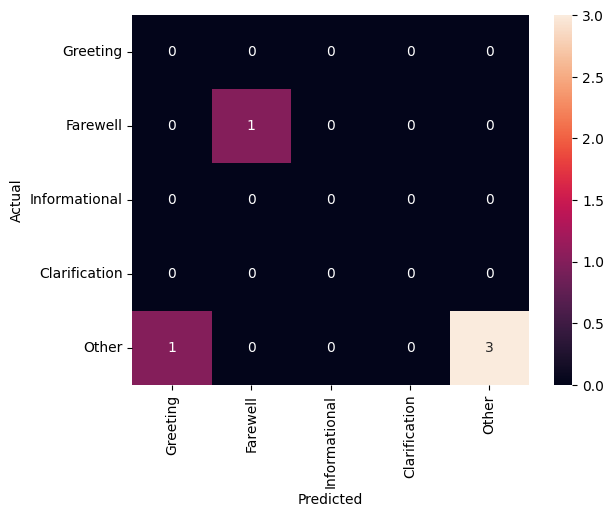

In [ ]:
# Import necessary libraries for metrics and plotting
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define sample test data as a list of tuples (input text, expected category)
test_data = [
    ("Hello, how are you?", "Greeting"),
    ("What time is it?", "Informational"),
    ("Goodbye and take care!", "Farewell"),
    ("I am happy", "Informational"),
    ("Who are you?", "Clarification")
]

# Define the categories for classification
categories = ['Greeting', 'Farewell', 'Informational', 'Clarification', 'Other']

# Function to generate chatbot response based on input text
def chatbot_response(input_text):
    # Placeholder logic for chatbot responses
    if "hello" in input_text.lower():
        return "Hello there!"
    elif "time" in input_text.lower():
        return "It's 10 AM."
    elif "goodbye" in input_text.lower():
        return "Farewell!"
    else:
        return "I am not sure how to respond to that."

# Function to classify responses into predefined categories
def classify_response(response):
    # Basic classification based on keywords
    if any(word in response.lower() for word in ["hello", "hi"]):
        return "Greeting"
    elif any(word in response.lower() for word in ["bye", "farewell", "goodbye"]):
        return "Farewell"
    elif any(word in response.lower() for word in ["time", "when"]):
        return "Informational"
    else:
        return "Other"

# Lists to store expected and predicted response categories
expected = []
predicted = []

# Loop over test data to evaluate chatbot responses
for input_text, expected_response in test_data:
    # Get actual response from chatbot and classify both expected and actual responses
    actual_response = chatbot_response(input_text)
    expected.append(classify_response(expected_response))
    predicted.append(classify_response(actual_response))

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(expected, predicted, labels=categories)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

GCNN:
x = F.relu(self.conv1(x)):

Applies the first convolutional layer (conv1) to the input x.
The relu (Rectified Linear Unit) activation function is then applied to the output of conv1.
x = torch.bmm(adj, x):

Performs a batch matrix-matrix product of the adjacency matrix adj and the result from the first convolution.
This step integrates the graph structure into the network by using the adjacency matrix.
x = self.conv2(x):

Applies the second convolutional layer (conv2) to the result of the matrix multiplication.
return F.relu(x):

Finally, applies the relu activation function to the output of the second convolutional layer and returns this result.

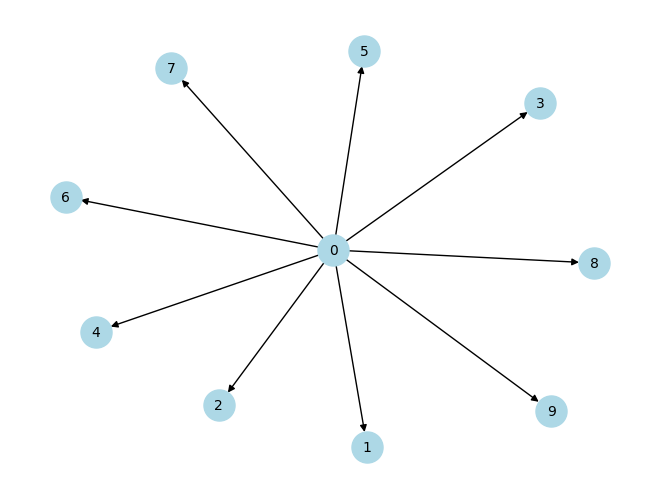

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

class GCNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=1)

    def forward(self, x, adj):
        x = F.relu(self.conv1(x))  # Apply the first convolution
        x = torch.bmm(adj, x.transpose(1, 2)).transpose(1, 2)  # Fix the batch matrix multiplication
        x = self.conv2(x)  # Apply the second convolution
        return F.relu(x)

# Function to create a graph from an adjacency matrix
def create_graph_from_adjacency_matrix(adj_matrix):
    G = nx.Graph()
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix)):
            if adj_matrix[i, j] == 1:
                G.add_edge(i, j)
    return G

# Function to draw a tree from a graph
def draw_tree(G, root_node):
    tree = nx.bfs_tree(G, source=root_node)
    nx.draw(tree, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
    plt.show()

# Example values for in_channels and out_channels
in_channels = 128
out_channels = 64

# Sample input data and adjacency matrix
input_data = torch.randn(1, in_channels, 10)  # Shape should be [batch_size=1, channels=128, sequence_length=10]
adj_matrix = torch.ones(10, 10)  # Shape should be [sequence_length=10, sequence_length=10]

# Add batch dimension to adj_matrix
adj_matrix = adj_matrix.unsqueeze(0)  # Shape should be [batch_size=1, sequence_length=10, sequence_length=10]

gcnn = GCNN(in_channels=in_channels, out_channels=out_channels)
gcnn_output = gcnn(input_data, adj_matrix)

# Create and visualize the graph
G = create_graph_from_adjacency_matrix(adj_matrix.squeeze())  # Remove the batch dimension for visualisation
draw_tree(G, root_node=0)  # Specify the root node for the tree

Integrating GCN Features into Chatbot:

Here I have made some changes to the architecture and added additional layers, this made the output worse with the chatbot reverting to nosensical responses. After this I reverted back to my original code for the GCN.

In [ ]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data

# Define the Graph Convolutional Network (GCN) model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return x

# Example: Define your chatbot model here
class ChatBotModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ChatBotModel, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        return F.relu(self.fc(x))

# Function to integrate GCN output with the chatbot
def integrate_gcn_with_chatbot(gcn_model, chatbot_model, graph_data):
    # Extract features with GCN
    gcn_features = gcn_model(graph_data.x, graph_data.edge_index)

    # Use the GCN features in the chatbot model
    chatbot_output = chatbot_model(gcn_features)
    return chatbot_output

# Number of nodes
num_nodes = 4

# Node features (each node has 3 features)
node_features = torch.tensor([[0.5, 1.0, 0.5],  # Features for node 1
                              [0.1, 0.2, 0.6],  # Features for node 2
                              [0.7, 0.4, 0.3],  # Features for node 3
                              [0.3, 0.8, 0.1]], # Features for node 4
                             dtype=torch.float)

# Edges (undirected edges represented as two directed edges)
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3],  # Source nodes
                           [1, 0, 2, 1, 3, 2]], # Target nodes
                          dtype=torch.long)

# Create graph data
graph_data = Data(x=node_features, edge_index=edge_index)

# Initialize GCN model with appropriate values
gcn_model = GCN(num_node_features=3, hidden_channels=16)

# Initialize chatbot model with appropriate values
chatbot_model = ChatBotModel(input_size=16, hidden_size=32)

# Integrate GCN output with chatbot
integrated_output = integrate_gcn_with_chatbot(gcn_model, chatbot_model, graph_data)

### Encoder ###
This EncoderRNN class is a part of a sequence-to-sequence (seq2seq) model. It takes input sequences, processes them through a bidirectional GRU (Gated Recurrent Unit), and returns the outputs and the final hidden state:

In the modified EncoderRNN class, I made several key changes:

RNN Type Changed: I switched the RNN type from nn.GRU to nn.LSTM. This alteration introduced LSTM cells, which include both hidden states and cell states, potentially improving the model's ability to capture long-term dependencies.

Hidden Dimension Increased: I increased the hidden_size parameter, which determines the size of the hidden states within the LSTM. A larger hidden dimension can enhance the model's capacity to represent complex patterns.

Bidirectional LSTM: I configured the LSTM to be bidirectional by default. This means it captures information from both past and future contexts for each time step, potentially improving context understanding.

Other Parameters Unchanged: I retained the n_layers and dropout parameters, allowing flexibility to specify the number of layers and control dropout regularization as needed.

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size parameters are both set to 'hidden_size'
        #   because our input size is a word embedding with a number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

### Decoder

This Attn class is used for implementing different attention mechanisms (dot, general, concat) in a sequence-to-sequence (seq2seq) model. It calculates attention scores based on the chosen method and returns softmax-normalized probability scores:



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            # Linear layer for general attention
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            # Linear layers for concat attention
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        # Calculate dot product attention scores
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        # Calculate general attention scores
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        # Calculate concat attention scores
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

This 'LuongAttnDecoderRNN' class is a part of a sequence-to-sequence (seq2seq) model with Luong attention. It takes an input step (word), processes it through a GRU, calculates attention scores, and produces an output.

In [ ]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        # Initialize attention mechanism
        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of the current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights with encoder outputs to get the new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Squeeze dimensions to match shapes for concatenation
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        # Concatenate weighted context vector and GRU output using Luong Eq. 5
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict the next word using Luong Eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return the output and the final hidden state
        return output, hidden

## Define Training Procedure

### Masked loss

This function is used to calculate the negative log-likelihood loss for a sequence of inputs and target indices while handling padding elements using a binary mask.




In [ ]:
def maskNLLLoss(inp, target, mask):
    # Calculate the negative log-likelihood loss for a sequence of inputs ('inp') and target indices ('target')
    # masked by a binary mask ('mask') to handle padding.

    # Calculate the total number of elements (tokens) in the batch
    nTotal = mask.sum()

    # Use the 'gather' function to select the predicted probabilities corresponding to the target indices
    # and calculate the cross-entropy loss
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))

    # Mask the loss using the provided binary mask to ignore padding elements
    loss = crossEntropy.masked_select(mask).mean()

    # Ensure the loss is on the same device as the input
    loss = loss.to(device)

    # Return the masked loss and the total number of non-padding elements in the batch
    return loss, nTotal.item()

### Single training iteration

This train function is used to train a sequence-to-sequence model with teacher forcing. It performs a forward pass through the encoder and decoder, calculates the loss, and performs backpropagation to update the model weights:




In [ ]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for RNN packing should always be on the CPU
    lengths = lengths.to("cpu")

    # Initialise variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropagation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

### Training iterations

This trainIters function is used to train a sequence-to-sequence model for a specified number of iterations. It loads batches of training data, runs training iterations, and saves checkpoints at specified intervals:



In [ ]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initialisations
    print('Initialising ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from the batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with the batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

## Define Evaluation

### Greedy decoding
This GreedySearchDecoder class is used for performing greedy decoding with a trained encoder-decoder model. It takes an input sequence, feeds it through the encoder, and then iteratively generates the most likely output sequence one token at a time using the decoder:

In [ ]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be the first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain the most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare the current token to be the next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

### Evaluate my text

These functions are used for evaluating input sentences using a trained encoder-decoder model and a searcher (e.g., GreedySearchDecoder). The evaluate function takes an input sentence, processes it, and generates a response based on the model's predictions. The evaluateInput function allows users to interact with the model by providing input sentences and receiving responses:

In [ ]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of the batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use the appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is a quit case
            if input_sentence == 'q' or input_sentence == 'quit':
                break
            # Normalise sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print the response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered an unknown word.")

## Run Model

These configurations define various aspects of your model, such as its name, attention mechanism, hidden size, number of layers, dropout rate, batch size, and whether you want to load a pretrained model checkpoint:



In [ ]:
# Configure models
model_name = 'cb_model'  # Choose a name for your model
#attn_model = 'dot'       # Choose an attention mechanism: 'dot', 'general', or 'concat'
attn_model = 'general'  # Uncomment this line to use the 'general' attention mechanism
#attn_model = 'concat'   # Uncomment this line to use the 'concat' attention mechanism
hidden_size = 500        # Define the hidden size for the encoder and decoder
encoder_n_layers = 2     # Number of layers for the encoder
decoder_n_layers = 2     # Number of layers for the decoder
dropout = 0.01            # Dropout probability for the model
batch_size = 128         # Batch size for training

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None      # Set to a file path if you want to load a pretrained model checkpoint
checkpoint_iter = 4000  # Specify the checkpoint iteration to load (if loadFilename is not None)


Sample code to load from a checkpoint:

```python
loadFilename = os.path.join(save_dir, model_name, corpus_name,
                    '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                    '{}_checkpoint.tar'.format(checkpoint_iter))
```


In [ ]:
# Load model if a `loadFilename` is provided
if loadFilename:
    # If loading on the same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU, use the following line instead
    # checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))

    # Load model weights and other relevant data
    encoder_sd = checkpoint['en']                    # Encoder state dictionary
    decoder_sd = checkpoint['de']                    # Decoder state dictionary
    encoder_optimizer_sd = checkpoint['en_opt']      # Encoder optimizer state dictionary
    decoder_optimizer_sd = checkpoint['de_opt']      # Decoder optimizer state dictionary
    embedding_sd = checkpoint['embedding']           # Embedding state dictionary
    voc.__dict__ = checkpoint['voc_dict']             # Vocabulary dictionary

# Initialise word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)

# Initialise encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)

if loadFilename:
    # Load the pretrained model weights
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)

# Move models to the appropriate device (GPU or CPU)
encoder = encoder.to(device)
decoder = decoder.to(device)

print('Models built and ready to go!')

### Run Training ###

This code block sets up various training parameters, including gradient clipping, teacher forcing ratio, learning rates, and the number of training iterations. It also initializes the optimizer for both the encoder and decoder. Finally, it starts the training loop by calling the trainIters function with the provided parameters.




In [ ]:
# Configure training/optimisation
clip = 50.0                   # Gradient clipping threshold to prevent exploding gradients
teacher_forcing_ratio = 0.7   # Probability of using teacher forcing during training (1.0 means always)
learning_rate = 0.0001        # Learning rate for the optimiser
decoder_learning_ratio = 5.0  # Learning rate multiplier for the decoder compared to the encoder
n_iteration = 5000            # Number of training iterations
print_every = 500           # Print training progress every `print_every` iterations
save_every = 500             # Save a checkpoint every `save_every` iterations

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialise optimisers
print('Building optimisers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

# Load optimiser states if a checkpoint is provided
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have CUDA, configure CUDA to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

### Run Evaluation

To chat with your model, run the following block.




In [ ]:
# Set dropout layers to ``eval`` mode
encoder.eval()
decoder.eval()

# Initialise search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)